In [20]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.applications import MobileNet

from keras import layers
from keras.layers import Dense, GlobalAveragePooling2D


## Preprocessing

In [2]:
# paths
local_drug_directory = 'local_drug_directory'
train_dir = "output/train/"
valid_dir = "output/val/"

In [3]:
# define loading parameters
img_height = 224
img_width = 224
batch_size = 1

In [4]:
# set up rescale 
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 437 images belonging to 23 classes.


In [6]:
# using ImageDataGenerator and flow_from_directory to preprocess the images
validation_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(img_width,img_height),
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                   )

Found 46 images belonging to 23 classes.


In [7]:
# to extract the class names for label
class_names = train_generator.class_indices.keys()
class_names

dict_keys(['Amoxicillin 500 mg', 'Apixaban 2.5 mg', 'Aprepitant 80 mg', 'Atomoxetine 25 mg', 'Calcitriol 0.00025', 'Prasugrel 10 MG', 'Ramipril 5 MG', 'Saxagliptin 5 MG', 'Sitagliptin 50 MG', 'Tadalafil 5 MG', 'carvedilol 3.125', 'celecoxib 200', 'duloxetine 30', 'eltrombopag 25', 'metformin_500', 'montelukast-10', 'mycophenolate-250', 'omeprazole_40', 'oseltamivir-45', 'pantaprazole-40', 'pitavastatin_1', 'prednisone_5', 'sertraline_25'])

-------
## Using MobileNet to train our data
-------

In [29]:
# define a base model with non trainable params
base_model = MobileNet(weights = 'imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [30]:
# set up our model and layers
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(23, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 23)                23575     
                                                                 
Total params: 3252439 (12.41 MB)
Trainable params: 23575 (92.09 KB)
Non-trainable params: 3228864 (12.32 MB)
_________________________________________________________________


In [31]:
# compile the model
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [32]:
# fit the model
model_fitted = model.fit(train_generator, epochs=2, validation_data = validation_generator)

Epoch 1/2
437/437 [==============================] - 22s 44ms/step - loss: 1.0693 - accuracy: 0.7712 - val_loss: 0.0790 - val_accuracy: 1.0000
Epoch 2/2
437/437 [==============================] - 19s 44ms/step - loss: 0.0559 - accuracy: 0.9977 - val_loss: 0.0245 - val_accuracy: 1.0000


In [33]:
# display training loss and training accuracy
model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
print(f" loss : {model_loss}, accuray : {model_accuracy}")

46/46 - 2s - loss: 0.0245 - accuracy: 1.0000 - 2s/epoch - 42ms/step
 loss : 0.02445477433502674, accuray : 1.0


In [ ]:
# save the model
# model.save('MobileNet_02.keras')

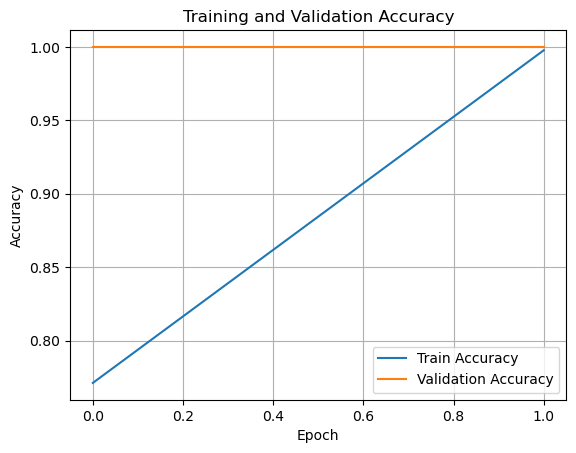

In [34]:
# Visualize the training and validation accuracy 
plt.plot(model_fitted.history['accuracy'], label='Train Accuracy')
plt.plot(model_fitted.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.show()

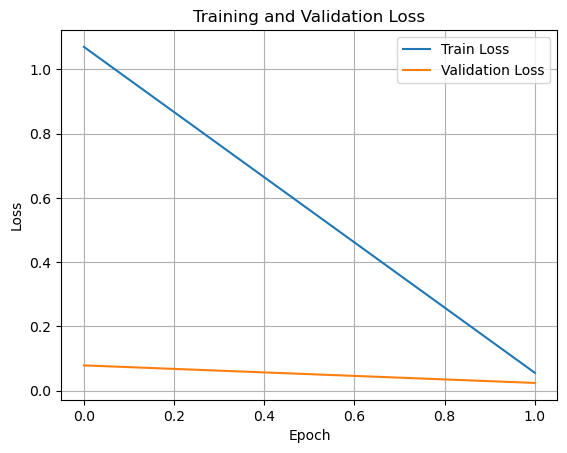

In [35]:
# Visualize the training and validation loss
plt.plot(model_fitted.history['loss'], label='Train Loss')
plt.plot(model_fitted.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()